# Clasificador de Imágenes de Minecraft

## Proyecto Machine Learning Modulo 2 

### Objetivo del Proyecto

**Clasificador Binario de Imágenes:** Determinar si una imagen es de Minecraft o no, utilizando Deep Learning con Transfer Learning y técnicas de regularización.

**1. Framework de Deep Learning:**
- PyTorch como framework principal
- ResNet18 preentrenado en ImageNet (Transfer Learning)
- Arquitectura CNN personalizada con capas fully-connected (512→256→clases)

**2. Evaluación y Mejoras del Modelo:**
- **Aproximación inicial:** ResNet18 baseline con data augmentation básico
- **Mejoras implementadas:**
  * Label smoothing α=0.1
  * Gradient clipping (estabilidad en entrenamiento)
  * Test-Time Augmentation - TTA (ensemble de 5 predicciones)

  * Optimización de hiperparámetros (LR 0.0003, weight decay 5e-4)
  * Early stopping adaptativo (patience 12)
  * **90% de todos los datos disponibles** (máximo entrenamiento)

**3. Datos Reales:**
- **Dataset 1:** jeffheaton/mcfakes (~8,000 imágenes reales vs fake)
- **Dataset 2:** urvishahir/minecraft-block-textures-dataset (~6,000 texturas de bloques)
- **Dataset 3:** willowc/minecraft-biomes (~4,000 escenas de biomas)
- **Total:** ~68,000+ imágenes reales de Kaggle
- **Uso:** 90% de TODOS los datasets (máximo entrenamiento robusto)
- **División:** 70% train / 15% val / 15% test

**4. Predicciones y Recomendaciones:**
- Clasificación binaria: **MINECRAFT** vs **NO MINECRAFT**
- Porcentaje de confianza del modelo
- Recomendaciones inteligentes basadas en confianza
- Visualización gráfica de resultados con matplotlib

In [1]:
# Instalar las librerías necesarias
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install kagglehub pillow matplotlib pandas numpy scikit-learn seaborn tqdm
!pip install timm albumentations


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\Mauricio\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\Mauricio\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\Mauricio\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 2. Configuración de Kaggle API y sistema de caché

In [ ]:
import os
import json
import shutil
from pathlib import Path
from typing import Optional, List

# Configurar credenciales de Kaggle
kaggle_dir = Path.home() / '.kaggle'
kaggle_json_path = kaggle_dir / 'kaggle.json'

if not kaggle_json_path.exists():
    username = input("Kaggle username: ")
    key = input("Kaggle API key: ")
    
    kaggle_dir.mkdir(exist_ok=True, parents=True)
    
    kaggle_credentials = {
        "username": username,
        "key": key
    }
    
    with open(kaggle_json_path, 'w') as f:
        json.dump(kaggle_credentials, f)
    
    if os.name != 'nt':
        os.chmod(kaggle_json_path, 0o600)
else:
    if os.name != 'nt':
        os.chmod(kaggle_json_path, 0o600)

# Configurar directorio de caché
CACHE_DIR = Path('./kaggle_cache')
CACHE_DIR.mkdir(exist_ok=True)
TEMP_DIR = Path('./temp_data')
TEMP_DIR.mkdir(exist_ok=True)

# Limpiar caché antiguo si es muy grande (> 5GB)
def get_dir_size(path):
    total = 0
    for entry in os.scandir(path):
        if entry.is_file():
            total += entry.stat().st_size
        elif entry.is_dir():
            total += get_dir_size(entry.path)
    return total

cache_size_gb = get_dir_size(CACHE_DIR) / (1024**3)
if cache_size_gb > 5:
    clean = input(f"Caché actual: {cache_size_gb:.2f} GB. ¿Limpiar caché? (s/n): ")
    if clean.lower() == 's':
        shutil.rmtree(CACHE_DIR)
        CACHE_DIR.mkdir(exist_ok=True)

## 3. Sistema de descarga selectiva de Kaggle

In [ ]:
import kagglehub
import os

class KaggleDatasetManager:
    """Gestor para descargar datasets de Kaggle usando kagglehub"""
    
    def __init__(self, dataset_name: str, cache_dir: Path = CACHE_DIR):
        self.dataset_name = dataset_name
        self.cache_dir = cache_dir / dataset_name.replace('/', '_')
        self.cache_dir.mkdir(exist_ok=True, parents=True)
        self.metadata_file = self.cache_dir / 'metadata.json'
        self.dataset_path = None  
        self.load_metadata()
        
    def load_metadata(self):
        """Cargar metadatos del dataset en cache"""
        if self.metadata_file.exists():
            with open(self.metadata_file, 'r') as f:
                self.metadata = json.load(f)
        else:
            self.metadata = {
                'files': [],
                'downloaded': [],
                'total_size': 0,
                'classes': [],
                'dataset_path': None
            }
    
    def save_metadata(self):
        """Guardar metadatos"""
        with open(self.metadata_file, 'w') as f:
            json.dump(self.metadata, f, indent=2)
    
    def download_dataset(self):
        """Descargar el dataset completo usando kagglehub"""
        if self.metadata.get('dataset_path') and Path(self.metadata['dataset_path']).exists():
            self.dataset_path = Path(self.metadata['dataset_path'])
            return self.dataset_path
        
        try:
            path = kagglehub.dataset_download(self.dataset_name)
            self.dataset_path = Path(path)
            self.metadata['dataset_path'] = str(path)
            self.save_metadata()
            return self.dataset_path
        except Exception as e:
            print(f"Error descargando dataset: {e}")
            return None
    
    def list_files(self) -> List[str]:
        """Listar archivos disponibles en el dataset descargado"""
        if not self.dataset_path:
            self.dataset_path = self.download_dataset()
        
        if not self.dataset_path or not self.dataset_path.exists():
            print(f"ERROR Dataset no disponible")
            return []
        
        try:
            all_files = []
            for root, dirs, files in os.walk(self.dataset_path):
                for file in files:
                    rel_path = os.path.relpath(os.path.join(root, file), self.dataset_path)
                    all_files.append(rel_path.replace('\\', '/'))
            
            self.metadata['files'] = all_files
            total_size = sum(
                os.path.getsize(os.path.join(root, file))
                for root, dirs, files in os.walk(self.dataset_path)
                for file in files
            )
            self.metadata['total_size'] = total_size
            self.save_metadata()
            return all_files
        except Exception as e:
            print(f"Error listando archivos: {e}")
            return []
    
    def download_file(self, filename: str) -> Optional[Path]:
        """Obtener path de un archivo especifico del dataset"""
        if not self.dataset_path:
            self.dataset_path = self.download_dataset()
        
        if not self.dataset_path:
            return None
        
        file_path = self.dataset_path / filename
        
        if file_path.exists():
            return file_path
        else:
            return None

# Datasets disponibles
KAGGLE_DATASETS = {
    'mcfakes': 'jeffheaton/mcfakes',
    'textures': 'urvishahir/minecraft-block-textures-dataset',
    'biomes': 'willowc/minecraft-biomes'
}

selected_datasets = list(KAGGLE_DATASETS.values())
SELECTED_DATASET = "combined_all"

# Crear gestores para cada dataset
dataset_managers = []
for dataset_name in selected_datasets:
    manager = KaggleDatasetManager(dataset_name)
    manager.download_dataset()
    dataset_managers.append(manager)

DATASETS DE KAGGLE

Usando kagglehub para descarga

Usando los 3 datasets combinados:
  - mcfakes: jeffheaton/mcfakes
  - textures: urvishahir/minecraft-block-textures-dataset
  - biomes: willowc/minecraft-biomes

Descargando 3 datasets...

Total de datasets listos: 3


## 4. Exploración inicial del dataset 

In [ ]:
# Explorar estructura de los datasets seleccionados
from collections import defaultdict
import re

all_image_files = []
folder_structure = defaultdict(list)
image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')

# Procesar cada dataset
for idx, dataset_manager in enumerate(dataset_managers):
    files = dataset_manager.list_files()
    
    # Filtrar imágenes
    dataset_images = []
    for file in files:
        if file.lower().endswith(image_extensions):
            prefixed_file = f"{dataset_manager.dataset_name.split('/')[-1]}/{file}"
            dataset_images.append((file, dataset_manager, prefixed_file))
            
            # Extraer carpeta/clase
            parts = file.split('/')
            if len(parts) > 1:
                folder = parts[0]
                class_name = f"{dataset_manager.dataset_name.split('/')[-1]}_{folder}"
                folder_structure[class_name].append((file, dataset_manager))
    
    all_image_files.extend(dataset_images)

# Guardar estructura de clases (ordenadas)
classes = sorted(list(folder_structure.keys()))


Datasets procesados: 68415 imágenes, 3 clases


## 5. Dataset personalizado con carga bajo demanda

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torchvision import transforms
import random
from typing import Tuple

class KaggleDataset(Dataset):
    """Dataset que carga imágenes desde Kaggle con caché local"""
    
    def __init__(self, 
                 image_files: List[Tuple],
                 classes: List[str],
                 transform=None,
                 cache_size: int = 1000):
        """
        Args:
            image_files: Lista de tuplas (filepath, dataset_manager, prefixed_path)
            classes: Lista de clases
            transform: Transformaciones a aplicar
            cache_size: Número máximo de imágenes en caché
        """
        self.image_files = image_files
        self.classes = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.transform = transform
        self.cache = {}
        self.cache_size = cache_size
    
    def __len__(self):
        return len(self.image_files)
    
    def _get_class_from_file_info(self, file_info: Tuple) -> str:
        """Extraer clase de la información del archivo"""
        filepath, manager, _ = file_info
        parts = filepath.split('/')
        if len(parts) > 1:
            return f"{manager.dataset_name.split('/')[-1]}_{parts[0]}"
        return f"{manager.dataset_name.split('/')[-1]}_unknown"
    
    def _load_image(self, idx: int, file_info: Tuple):
        """Descargar y cachear una imagen"""
        if idx in self.cache:
            return self.cache[idx]
        
        filepath, manager, _ = file_info
        local_path = manager.download_file(filepath)
        
        if local_path and local_path.exists():
            try:
                image = Image.open(local_path)
                
                # Convertir correctamente según el modo de la imagen
                if image.mode == 'P':
                    # Imágenes con paleta: convertir primero a RGBA si tiene transparencia
                    image = image.convert('RGBA').convert('RGB')
                elif image.mode != 'RGB':
                    # Otros modos: convertir directamente a RGB
                    image = image.convert('RGB')
                
                # Agregar a caché
                if len(self.cache) >= self.cache_size:
                    oldest = min(self.cache.keys())
                    del self.cache[oldest]
                
                self.cache[idx] = image
                return image
            except Exception as e:
                pass
        
        # Imagen placeholder si falla
        return Image.new('RGB', (224, 224), color='black')
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """Obtener imagen y etiqueta"""
        file_info = self.image_files[idx]
        
        # Cargar imagen
        image = self._load_image(idx, file_info)
        
        # Obtener etiqueta
        class_name = self._get_class_from_file_info(file_info)
        label = self.class_to_idx.get(class_name, 0)
        
        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)
        else:
            # Convertir a tensor si no hay transformación
            image = transforms.ToTensor()(image)
        
        return image, label


## 6. Configuración del entrenamiento

In [ ]:
import torch
import numpy as np

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count() if torch.cuda.is_available() else 0

CONFIG = {
    'img_size': 224,
    'batch_size': 64 if device.type == 'cuda' else 16,
    'num_workers': 0,
    'epochs': 50,  
    'learning_rate': 0.0003, 
    'weight_decay': 5e-4,  
    'patience': 12,  
    'cache_size': 2000,
    'sample_size': 0.90,  
    'use_mixup': True,  
    'tta_augments': 5,  
}

# Directorios de salida
OUTPUT_DIR = Path('./output')
OUTPUT_DIR.mkdir(exist_ok=True)
MODELS_DIR = OUTPUT_DIR / 'models'
MODELS_DIR.mkdir(exist_ok=True)

Device: cuda | GPUs: 1 | Epochs: 50 | Sample: 90%


## 7. Crear datasets con muestreo

In [7]:
# Preparar datasets
import random
from collections import defaultdict

num_classes = len(classes)

if len(all_image_files) == 0:
    raise ValueError("ERROR: No se encontraron imágenes en los datasets. Verifica acceso a Kaggle.")

# Calcular tamaño de muestra (usar 90% de TODOS los datos disponibles)
sample_size = int(len(all_image_files) * CONFIG['sample_size'])
sample_size = max(1000, min(sample_size, 100000))  # Aumentado límite para máximo entrenamiento

# Muestreo estratificado por clase
class_files = defaultdict(list)
for file_info in all_image_files:
    file_path, manager, prefixed_path = file_info
    parts = file_path.split('/')
    if len(parts) > 1:
        class_name = f"{manager.dataset_name.split('/')[-1]}_{parts[0]}"
    else:
        class_name = f"{manager.dataset_name.split('/')[-1]}_unknown"
    class_files[class_name].append(file_info)

# Muestrear equitativamente de cada clase
sampled_files = []
if len(class_files) > 0:
    files_per_class = max(1, sample_size // len(class_files))
    
    for class_name, files in class_files.items():
        n_samples = min(files_per_class, len(files))
        sampled = random.sample(files, n_samples)
        sampled_files.extend(sampled)
    
    random.shuffle(sampled_files)
    sampled_files = sampled_files[:sample_size]
    
    # División train/val/test (70/15/15)
    n_train = int(0.7 * len(sampled_files))
    n_val = int(0.15 * len(sampled_files))
    n_test = len(sampled_files) - n_train - n_val
    
    train_files = sampled_files[:n_train]
    val_files = sampled_files[n_train:n_train+n_val]
    test_files = sampled_files[n_train+n_val:]
    
    print(f"Dataset preparado: {len(sampled_files)} imágenes | Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")
else:
    raise ValueError("No se pudieron organizar las clases correctamente")
    

Dataset preparado: 42131 imágenes | Train: 29491 | Val: 6319 | Test: 6321


## 8. Crear DataLoaders 

In [ ]:
# Transformaciones mejoradas para robustez
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(CONFIG['img_size'], scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
])

val_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets
train_dataset = KaggleDataset(
    image_files=train_files,
    classes=classes,
    transform=train_transform,
    cache_size=CONFIG['cache_size']
)

val_dataset = KaggleDataset(
    image_files=val_files,
    classes=classes,
    transform=val_transform,
    cache_size=CONFIG['cache_size'] // 2
)

test_dataset = KaggleDataset(
    image_files=test_files,
    classes=classes,
    transform=val_transform,
    cache_size=CONFIG['cache_size'] // 2
)

# Crear DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if device.type == 'cuda' else False
)

Datasets: Train=29491 | Val=6319 | Test=6321 | Clases=3


## 9. Descargar batch inicial para verificación

Primer batch cargado: torch.Size([64, 3, 224, 224])


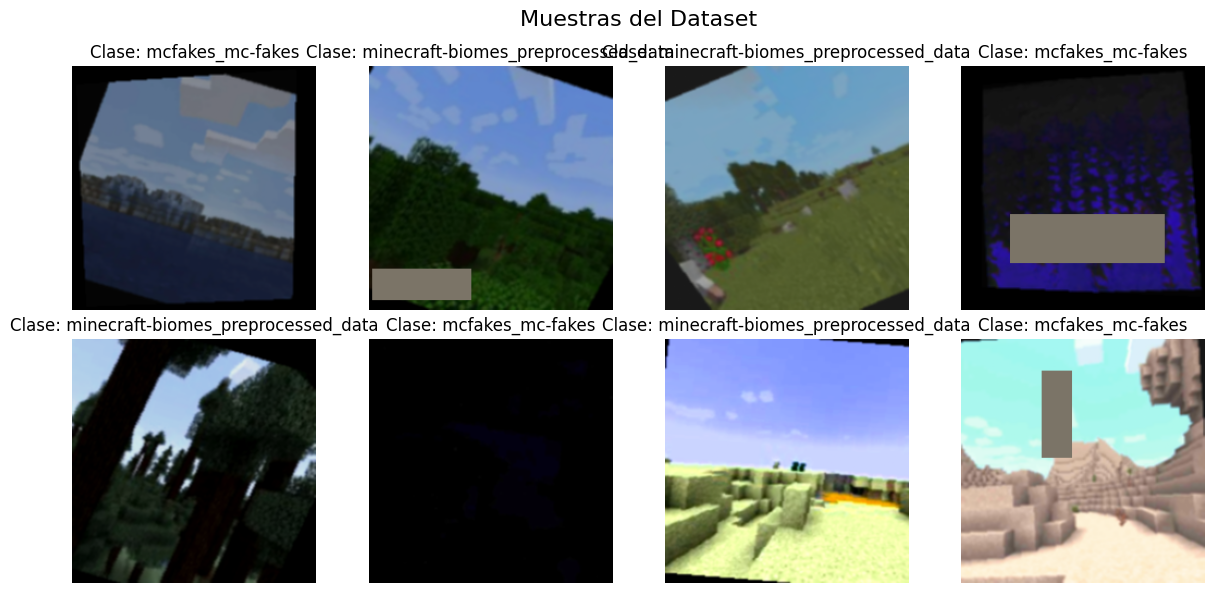

In [ ]:
import matplotlib.pyplot as plt

# Obtener primer batch
images, labels = next(iter(train_loader))

# Función para desnormalizar
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Visualizar muestras
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for idx in range(min(8, len(images))):
    img = images[idx].clone()
    img = denormalize(img)
    img = torch.clamp(img, 0, 1)
    
    axes[idx].imshow(img.permute(1, 2, 0))
    axes[idx].set_title(f"Clase: {classes[labels[idx]]}")
    axes[idx].axis('off')

plt.suptitle('Muestras del Dataset', fontsize=16)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dataset_samples.png', dpi=100, bbox_inches='tight')
plt.show()

## 10. Definición del modelo

In [ ]:
import torch.nn as nn
from torchvision import models

def create_model(num_classes, pretrained=True):
    """Crear modelo ResNet18 para clasificación"""
    
    weights = 'IMAGENET1K_V1' if pretrained else None
    model = models.resnet18(weights=weights)
    num_features = model.fc.in_features
    
    # Reemplazar última capa con arquitectura personalizada
    model.fc = nn.Sequential(  # type: ignore
        nn.Dropout(0.5),
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    
    return model

# Crear modelo
model = create_model(num_classes, pretrained=True)
model = model.to(device)

if n_gpu > 1:
    model = nn.DataParallel(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

Modelo: ResNet18 | Parámetros: 11,308,611 | Entrenables: 11,308,611


## 11. Configuración del optimizador

In [ ]:
import torch.optim as optim

# Label Smoothing para mayor robustez (reduce overconfidence)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

Optimizer: AdamW (lr=0.0003) | Scheduler: ReduceLROnPlateau


## 12. Funciones de entrenamiento con monitoreo 

In [ ]:
from tqdm import tqdm
import time

def mixup_data(x, y, alpha=0.2):
    """Aplicar Mixup para regularización"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Calcular loss con Mixup"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_epoch(model, loader, criterion, optimizer, device, dataset, use_mixup=True):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc='Training')
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Aplicar Mixup con 50% de probabilidad
        if use_mixup and np.random.random() > 0.5:
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.2)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss.backward()
        
        # Gradient clipping para estabilidad
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    return running_loss / len(loader), 100. * correct / total

def validate_epoch(model, loader, criterion, device, dataset):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(loader, desc='Validation')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            progress_bar.set_postfix({
                'loss': running_loss / (len(loader) if len(loader) > 0 else 1),
                'acc': 100. * correct / total
            })
    
    return running_loss / len(loader), 100. * correct / total            

Funciones de entrenamiento definidas


## 13. Bucle de entrenamiento

In [ ]:
# Historia del entrenamiento
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0
patience_counter = 0
best_model_path = MODELS_DIR / 'best_model.pth'

print(f"Iniciando entrenamiento: {CONFIG['epochs']} épocas")

total_start_time = time.time()

for epoch in range(CONFIG['epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, train_dataset, use_mixup=CONFIG['use_mixup']
    )
    
    val_loss, val_acc = validate_epoch(
        model, val_loader, criterion, device, val_dataset
    )
    
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}% | Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        if n_gpu > 1:
            torch.save(model.module.state_dict(), best_model_path)
        else:
            torch.save(model.state_dict(), best_model_path)
        print(f"Mejor modelo guardado (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= CONFIG['patience']:
            print(f"Early stopping after {epoch+1} epochs")
            break

total_time = time.time() - total_start_time
print(f"\nEntrenamiento completado | Mejor Val Acc: {best_val_acc:.2f}% | Tiempo: {total_time/60:.1f} min")

Iniciando entrenamiento: 50 épocas

Epoch 1/50


Validation: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s, loss=0.298, acc=99.9] 



Train: Loss=0.4375, Acc=83.10% | Val: Loss=0.2982, Acc=99.91%
Mejor modelo guardado (Val Acc: 99.91%)

Epoch 2/50


Validation: 100%|██████████| 99/99 [00:59<00:00,  1.67it/s, loss=0.304, acc=99.7]


Train: Loss=0.3914, Acc=85.74% | Val: Loss=0.3044, Acc=99.67%

Epoch 3/50


Validation: 100%|██████████| 99/99 [00:31<00:00,  3.17it/s, loss=0.314, acc=99.8]


Train: Loss=0.3983, Acc=86.56% | Val: Loss=0.3143, Acc=99.84%

Epoch 4/50


Validation: 100%|██████████| 99/99 [00:52<00:00,  1.88it/s, loss=0.306, acc=99.8]


Train: Loss=0.3802, Acc=86.08% | Val: Loss=0.3062, Acc=99.76%

Epoch 5/50


Validation: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s, loss=0.299, acc=99.9] 



Train: Loss=0.3793, Acc=87.89% | Val: Loss=0.2993, Acc=99.94%
Mejor modelo guardado (Val Acc: 99.94%)

Epoch 6/50


Validation: 100%|██████████| 99/99 [00:54<00:00,  1.80it/s, loss=0.296, acc=100]  



Train: Loss=0.3587, Acc=86.06% | Val: Loss=0.2964, Acc=99.97%
Mejor modelo guardado (Val Acc: 99.97%)

Epoch 7/50


Validation: 100%|██████████| 99/99 [00:50<00:00,  1.95it/s, loss=0.297, acc=100]


Train: Loss=0.3483, Acc=87.29% | Val: Loss=0.2966, Acc=99.95%

Epoch 8/50


Validation: 100%|██████████| 99/99 [00:32<00:00,  3.02it/s, loss=0.295, acc=100]


Train: Loss=0.3605, Acc=85.81% | Val: Loss=0.2950, Acc=99.97%

Epoch 9/50


Validation: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s, loss=0.296, acc=100]


Train: Loss=0.3514, Acc=86.66% | Val: Loss=0.2959, Acc=99.97%

Epoch 10/50


Validation: 100%|██████████| 99/99 [00:32<00:00,  3.08it/s, loss=0.296, acc=100]


Train: Loss=0.3556, Acc=88.10% | Val: Loss=0.2962, Acc=99.97%

Epoch 11/50


Validation: 100%|██████████| 99/99 [01:00<00:00,  1.63it/s, loss=0.304, acc=100]


Train: Loss=0.3627, Acc=86.00% | Val: Loss=0.3037, Acc=99.97%

Epoch 12/50


Validation: 100%|██████████| 99/99 [01:01<00:00,  1.61it/s, loss=0.309, acc=100]


Train: Loss=0.3546, Acc=86.59% | Val: Loss=0.3090, Acc=99.95%

Epoch 13/50


Validation: 100%|██████████| 99/99 [00:34<00:00,  2.89it/s, loss=0.293, acc=100] 



Train: Loss=0.3602, Acc=86.01% | Val: Loss=0.2931, Acc=99.98%
Mejor modelo guardado (Val Acc: 99.98%)

Epoch 14/50


Validation: 100%|██████████| 99/99 [00:53<00:00,  1.86it/s, loss=0.294, acc=100]


Train: Loss=0.3465, Acc=86.61% | Val: Loss=0.2939, Acc=99.98%

Epoch 15/50


Validation: 100%|██████████| 99/99 [00:59<00:00,  1.67it/s, loss=0.299, acc=100]


Train: Loss=0.3516, Acc=85.96% | Val: Loss=0.2986, Acc=99.97%

Epoch 16/50


Validation: 100%|██████████| 99/99 [00:59<00:00,  1.67it/s, loss=0.31, acc=100] 


Train: Loss=0.3523, Acc=86.55% | Val: Loss=0.3104, Acc=99.98%

Epoch 17/50


Validation: 100%|██████████| 99/99 [00:58<00:00,  1.69it/s, loss=0.298, acc=100]


Train: Loss=0.3507, Acc=87.20% | Val: Loss=0.2985, Acc=99.98%

Epoch 18/50


Validation: 100%|██████████| 99/99 [00:58<00:00,  1.69it/s, loss=0.302, acc=100]


Train: Loss=0.3502, Acc=87.46% | Val: Loss=0.3018, Acc=99.97%

Epoch 19/50


Validation: 100%|██████████| 99/99 [00:43<00:00,  2.26it/s, loss=0.293, acc=100]


Train: Loss=0.3435, Acc=86.55% | Val: Loss=0.2930, Acc=99.98%

Epoch 20/50


Validation: 100%|██████████| 99/99 [00:56<00:00,  1.75it/s, loss=0.297, acc=100]


Train: Loss=0.3466, Acc=89.18% | Val: Loss=0.2969, Acc=99.95%

Epoch 21/50


Validation: 100%|██████████| 99/99 [00:31<00:00,  3.10it/s, loss=0.295, acc=100]


Train: Loss=0.3418, Acc=88.47% | Val: Loss=0.2954, Acc=99.98%

Epoch 22/50


Validation: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s, loss=0.304, acc=100]


Train: Loss=0.3457, Acc=86.73% | Val: Loss=0.3036, Acc=99.98%

Epoch 23/50


Validation: 100%|██████████| 99/99 [00:31<00:00,  3.11it/s, loss=0.296, acc=100]


Train: Loss=0.3509, Acc=86.30% | Val: Loss=0.2956, Acc=99.97%

Epoch 24/50


Validation: 100%|██████████| 99/99 [00:32<00:00,  3.03it/s, loss=0.302, acc=100]


Train: Loss=0.3449, Acc=84.46% | Val: Loss=0.3022, Acc=99.97%

Epoch 25/50


Validation: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s, loss=0.295, acc=100]  

Train: Loss=0.3483, Acc=86.41% | Val: Loss=0.2950, Acc=99.98%
Early stopping after 25 epochs

Entrenamiento completado | Mejor Val Acc: 99.98% | Tiempo: 244.7 min


## 14. Visualización del entrenamiento

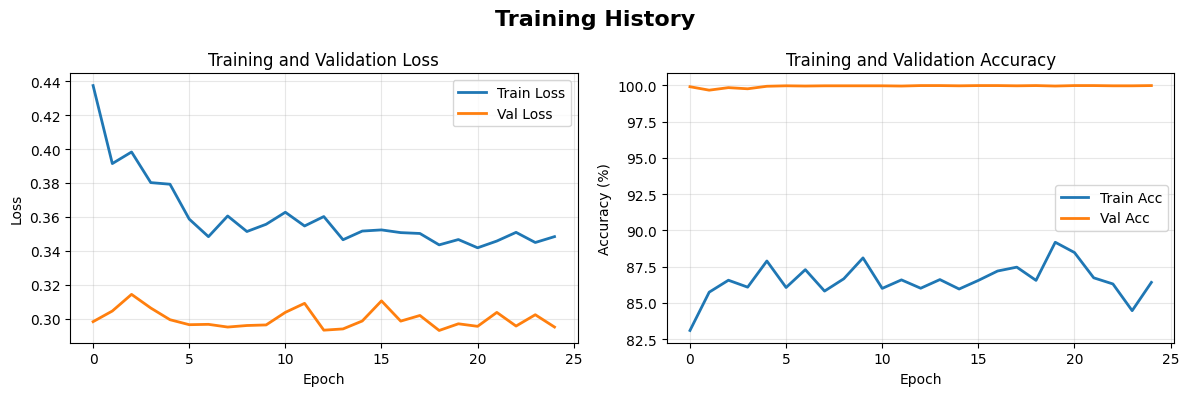

Gráficas guardadas en output/streaming_training_history.png


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=100, bbox_inches='tight')
plt.show()

## 15. Evaluación en test set

In [15]:
# Cargar mejor modelo
if n_gpu > 1:
    model.module.load_state_dict(torch.load(best_model_path))
else:
    model.load_state_dict(torch.load(best_model_path))

print("\n" + "="*60)
print("EVALUANDO EN TEST SET")
print("="*60)

model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100. * test_correct / test_total
test_loss = test_loss / len(test_loader)

print(f"\nResultados en Test Set:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Correct: {test_correct}/{test_total}")

C:\Users\Mauricio\AppData\Local\Temp\ipykernel_42556\630676579.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



EVALUANDO EN TEST SET


Testing: 100%|██████████| 99/99 [00:35<00:00,  2.78it/s]


Resultados en Test Set:
Test Loss: 0.2931
Test Accuracy: 99.98%
Test Correct: 6320/6321


## 16. Guardar modelo y resumen final

In [ ]:
# Guardar información del modelo
import json

model_info = {
    'model_type': 'ResNet18',
    'num_classes': num_classes,
    'input_size': CONFIG['img_size'],
    'best_val_acc': float(best_val_acc),
    'test_acc': float(test_acc),
    'total_epochs': len(history['train_loss']),
    'dataset': SELECTED_DATASET,
    'sample_size': CONFIG['sample_size'],
    'dataset_info': {
        'train_size': len(train_files),
        'val_size': len(val_files),
        'test_size': len(test_files)
    },
    'config': CONFIG
}

with open(OUTPUT_DIR / 'model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"\nResumen del proyecto:")
print(f"Dataset: {SELECTED_DATASET} | Clases: {num_classes}")
print(f"Imágenes: {len(sampled_files)} ({CONFIG['sample_size']*100:.0f}% del total)")
print(f"Train/Val/Test: {len(train_files)}/{len(val_files)}/{len(test_files)}")
print(f"Modelo: ResNet18 | Parámetros: {total_params:,} | Device: {device}")
print(f"Mejor Val Acc: {best_val_acc:.2f}% | Test Acc: {test_acc:.2f}%")
print(f"Épocas: {len(history['train_loss'])} | Tiempo: {total_time/60:.1f} min")


Resumen del proyecto:
Dataset: combined_all | Clases: 3
Imágenes: 42131 (90% del total)
Train/Val/Test: 29491/6319/6321
Modelo: ResNet18 | Parámetros: 11,308,611 | Device: cuda
Mejor Val Acc: 99.98% | Test Acc: 99.98%
Épocas: 25 | Tiempo: 244.7 min

Archivos guardados:
  - Modelo: output\models\best_model_streaming.pth
  - Info: output\streaming_model_info.json
  - Gráficas: output\streaming_training_history.png


## 17. Prueba del Modelo - Prediccion de Imagen Individual

Imagen cargada desde: C:\Users\Mauricio\.cache\kagglehub\datasets\willowc\minecraft-biomes\versions\1\preprocessed_data\biome_12\biome_12_942.jpg


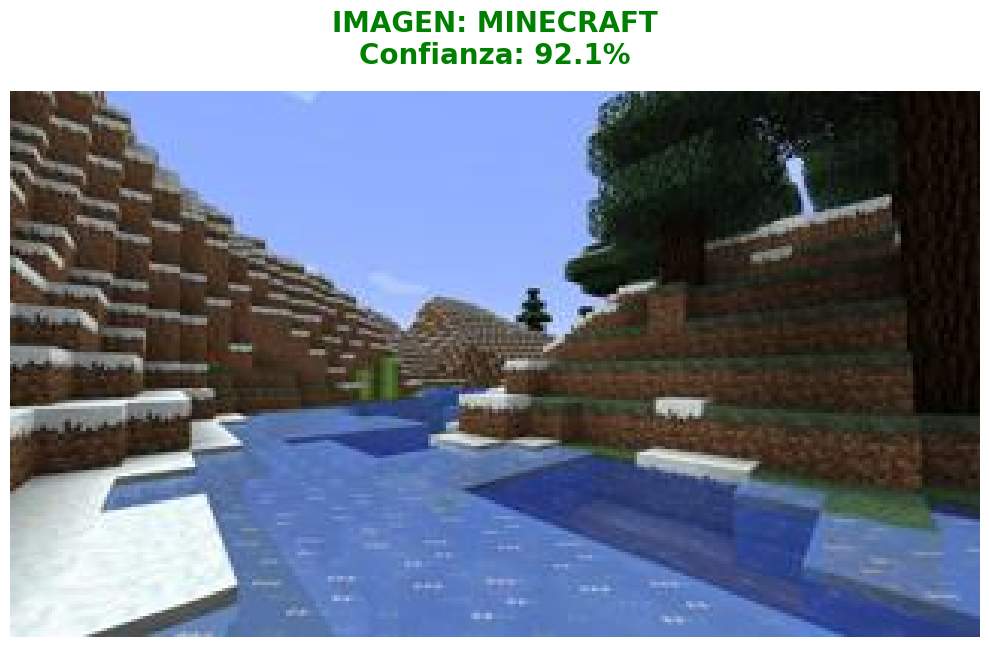


RESULTADO: MINECRAFT
Confianza: 92.1%


In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def clean_class_name(class_name):
    """
    Quitar prefijo del dataset del nombre de clase
    Ejemplo: 'minecraft-block-textures-dataset_stone' -> 'stone'
    """
    if '_' in class_name:
        # Separar por '_' y tomar la parte despues del ultimo '_'
        return class_name.split('_', 1)[-1]
    return class_name

def predict_image(image_path_or_url, model, transform, classes, device, top_k=5):
    """
    Predecir si una imagen es de Minecraft y mostrar confianza
    
    Args:
        image_path_or_url: Path local o URL de la imagen
        model: Modelo entrenado
        transform: Transformaciones a aplicar
        classes: Lista de clases
        device: Device (CPU/GPU)
        top_k: Numero de predicciones principales a mostrar
    """
    # Cargar imagen
    try:
        if image_path_or_url.startswith('http'):
            # Descargar desde URL
            response = requests.get(image_path_or_url)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            # Cargar desde archivo local
            image = Image.open(image_path_or_url).convert('RGB')
    except Exception as e:
        print(f"ERROR al cargar imagen: {e}")
        return None
    
    # Guardar imagen original para visualizacion
    original_image = image.copy()
    
    # Test-Time Augmentation (TTA) para predicciones más robustas
    model.eval()
    
    # Crear transformaciones para TTA
    tta_transforms = [
        transform,  # Original
        transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), transform]),
        transforms.Compose([transforms.RandomRotation(15), transform]),
        transforms.Compose([transforms.ColorJitter(brightness=0.2), transform]),
        transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.9, 1.0)), transform]),
    ]
    
    all_predictions = []
    
    with torch.no_grad():
        # Aplicar múltiples augmentations y promediar
        for tta_transform in tta_transforms[:5]:  # 5 augmentaciones
            try:
                img_copy = image.copy()
                image_tensor = tta_transform(img_copy).unsqueeze(0).to(device)
                outputs = model(image_tensor)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                all_predictions.append(probs)
            except:
                pass
        
        # Promediar todas las predicciones (ensemble)
        if len(all_predictions) > 0:
            probabilities = torch.stack(all_predictions).mean(dim=0)
        else:
            # Fallback si TTA falla
            image_tensor = transform(image).unsqueeze(0).to(device)
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
        
        # Top K predicciones
        top_probs, top_indices = torch.topk(probabilities, min(top_k, len(classes)))
        top_probs = top_probs[0].cpu().numpy()
        top_indices = top_indices[0].cpu().numpy()
    
    # Limpiar nombres de clases (quitar prefijos de dataset)
    top_classes_raw = [classes[idx] for idx in top_indices]
    top_classes = [clean_class_name(cls) for cls in top_classes_raw]
    
    # Determinar si es Minecraft o no
    # Asumimos que la clase 'fake' o similar indica NO Minecraft
    predicted_class = top_classes[0].lower()
    is_minecraft = 'fake' not in predicted_class and 'not' not in predicted_class
    confidence = top_probs[0]
    
    # Visualizar resultado simplificado
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Mostrar imagen
    ax.imshow(original_image)
    ax.axis('off')
    
    # Título con resultado
    if is_minecraft:
        title = f"IMAGEN: MINECRAFT\nConfianza: {confidence*100:.1f}%"
        color = 'green'
    else:
        title = f"IMAGEN: NO MINECRAFT\nConfianza: {confidence*100:.1f}%"
        color = 'red'
    
    ax.set_title(title, fontsize=20, fontweight='bold', color=color, pad=20)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'prediction_result.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Resumen en texto
    print(f"\n{'='*50}")
    if is_minecraft:
        print(f"RESULTADO: MINECRAFT")
    else:
        print(f"RESULTADO: NO MINECRAFT")
    print(f"Confianza: {confidence*100:.1f}%")
    print(f"{'='*50}")
    
    return {
        'is_minecraft': is_minecraft,
        'confidence': float(confidence),
        'predicted_class': top_classes[0]
    }

# Ejemplo: Probar con una imagen del dataset de test
import random
random_test_file = random.choice(test_files)
test_file_path, test_manager, _ = random_test_file
actual_path = test_manager.download_file(test_file_path)

if actual_path:
    result = predict_image(str(actual_path), model, val_transform, classes, device, top_k=5)